/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.6380 - loss: 9.6892 - val_accuracy: 0.6154 - val_loss: 0.9327 - learning_rate: 0.0010
Epoch 2/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.8417 - loss: 0.7130 - val_accuracy: 0.6923 - val_loss: 0.6120 - learning_rate: 0.0010
Epoch 3/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9044 - loss: 0.7682 - val_accuracy: 0.6154 - val_loss: 0.6769 - learning_rate: 0.0010
Epoch 4/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8814 - loss: 0.3776 - val_accuracy: 0.6923 - val_loss: 0.5470 - learning_rate: 0.0010
Epoch 5/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9941 - loss: 0.0856 - val_accuracy: 0.6923 - val_loss: 0.5467 - learning_rate: 0.0010
Epoch 6/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9342 - loss: 0.1695 - val_accuracy: 0.6923 - val_loss: 0.5798 - learning_rate: 0.0010
Epoch 7/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9957 - loss: 0.0447 - val_accuracy: 0.7692 

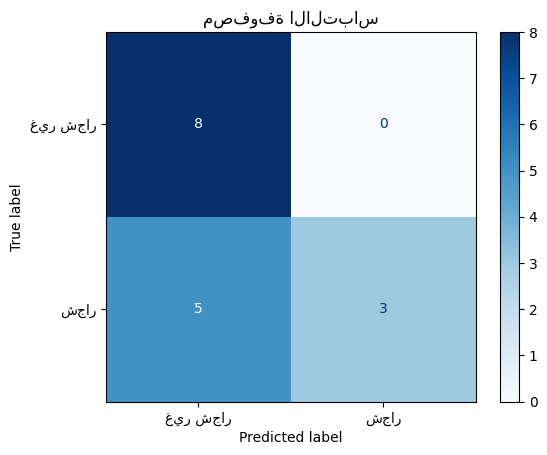

✅ تم حفظ النموذج بنجاح.


In [3]:
# ✅ 1. تحميل المكتبات
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ 2. فك الضغط (بعد رفع archive.zip إلى ملفات Colab)
zip_path = "/content/archive.zip"
extract_path = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ✅ 3. دالة استخراج الإطارات
def extract_frames(video_path, max_frames=30, size=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    while cap.isOpened() and count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame / 255.0
        frames.append(frame)
        count += 1
    cap.release()
    if len(frames) < max_frames:
        return None
    return np.array(frames)

# ✅ 4. تحميل وتصنيف الفيديوهات حسب الاسم (fi = شجار / no = غير شجار)
def load_dataset(base_dir, limit=40):
    X, y = [], []
    count_fight = count_non = 0
    for file in os.listdir(base_dir):
        if file.endswith(".avi"):
            path = os.path.join(base_dir, file)
            frames = extract_frames(path)
            if frames is not None:
                if file.startswith("fi") and count_fight < limit:
                    X.append(frames)
                    y.append(1)
                    count_fight += 1
                elif file.startswith("no") and count_non < limit:
                    X.append(frames)
                    y.append(0)
                    count_non += 1
    return np.array(X), np.array(y)

# ✅ 5. تحميل البيانات
video_path = "/content/dataset/data"
X, y = load_dataset(video_path, limit=40)
X = X[..., np.newaxis]  # قناة رمادية

# ✅ 6. تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# ✅ 7. بناء نموذج خفيف ومحسن
model = Sequential([
    ConvLSTM2D(filters=24, kernel_size=(3,3), activation='relu', input_shape=(X.shape[1], X.shape[2], X.shape[3], 1)),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ✅ 8. التدريب
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2)
]

history = model.fit(X_train, y_train, validation_split=0.2, epochs=8, batch_size=4, callbacks=callbacks, verbose=1)

# ✅ 9. التقييم
y_pred = model.predict(X_test).flatten()
y_pred_labels = [1 if p > 0.5 else 0 for p in y_pred]

print(classification_report(y_test, y_pred_labels, target_names=["غير شجار", "شجار"]))
cm = confusion_matrix(y_test, y_pred_labels)
ConfusionMatrixDisplay(cm, display_labels=["غير شجار", "شجار"]).plot(cmap="Blues")
plt.title("مصفوفة الالتباس")
plt.show()

# ✅ 10. حفظ النموذج
model.save("/content/fight_detection_model_fast_v2.h5")
print("✅ تم حفظ النموذج بنجاح.")


In [4]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
from IPython.display import HTML
from base64 import b64encode

# تحميل النموذج المدرب مسبقًا
model = load_model("/content/fight_detection_model_fast_v2.h5")

# تحويل الفيديو إلى mp4 إذا لم يكن كذلك
def ensure_mp4_format(input_path):
    if input_path.lower().endswith(".mp4"):
        return input_path
    output_path = input_path.rsplit(".", 1)[0] + ".mp4"
    if not os.path.exists(output_path):
        print(f"🔄 تحويل {input_path} إلى mp4...")
        os.system(f"ffmpeg -i \"{input_path}\" -vcodec libx264 -acodec aac \"{output_path}\"")
    return output_path

# استخراج الإطارات الرمادية بالحجم الصحيح
def extract_frames(video_path, max_frames=20, size=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    while cap.isOpened() and count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # تحويل إلى رمادي
        frame = frame / 255.0
        frames.append(frame)
        count += 1
    cap.release()
    return np.array(frames)[..., np.newaxis]  # (20, 64, 64, 1)

# تصنيف الفيديو
def predict_video_class(video_path):
    frames = extract_frames(video_path)
    if len(frames) == 0:
        return "فشل في تحميل الإطارات"
    frames = np.expand_dims(frames, axis=0)  # (1, 20, 64, 64, 1)
    prediction = model.predict(frames)[0][0]
    confidence = round(prediction * 100, 2)
    label = "شجار" if prediction > 0.5 else "غير شجار"
    return f"{label} (نسبة الثقة: {confidence}%)"

# عرض الفيديو مع التصنيف
def display_two_videos_with_predictions(fight_video_path, nonfight_video_path):
    fight_mp4 = ensure_mp4_format(fight_video_path)
    nonfight_mp4 = ensure_mp4_format(nonfight_video_path)

    fight_pred = predict_video_class(fight_mp4)
    nonfight_pred = predict_video_class(nonfight_mp4)

    with open(fight_mp4, 'rb') as f:
        fight_encoded = b64encode(f.read()).decode()

    with open(nonfight_mp4, 'rb') as f:
        nonfight_encoded = b64encode(f.read()).decode()

    html = f"""
    <table>
        <tr>
            <th>فيديو شجار</th>
            <th>فيديو غير شجار</th>
        </tr>
        <tr>
            <td>
                <video width="320" height="240" controls>
                    <source src="data:video/mp4;base64,{fight_encoded}" type="video/mp4">
                </video>
                <p><strong>{fight_pred}</strong></p>
            </td>
            <td>
                <video width="320" height="240" controls>
                    <source src="data:video/mp4;base64,{nonfight_encoded}" type="video/mp4">
                </video>
                <p><strong>{nonfight_pred}</strong></p>
            </td>
        </tr>
    </table>
    """
    return HTML(html)

# 🟩 عيّنات الفيديوهات للتجربة
fight_video = "/content/dataset/data/fi25_xvid.avi"
nonfight_video = "/content/dataset/data/no386_xvid.avi"

# 🟦 عرض النتائج
display_two_videos_with_predictions(fight_video, nonfight_video)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


فيديو شجار,فيديو غير شجار
